# Machine Learning in PyTorch
7/3/2020  

PyTorch is another python machine learning library similar to scikit-learn. PyTorch is designed for deep learning, giving it more flexibility when creating neural networks.  

## Logistic Regression

Begin with imports:

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from ray import tune

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
import seaborn as sn
import pandas as pd
import numpy as np
from livelossplot import PlotLosses

The full MNIST dataset is split into training and validation sets. A batch size is also defined for stochastic gradient descent:

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))]) #[-1,1]
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)
dataloaders = {'train':trainloader, 'validation': testloader}

Let's show all digits in a single batch:

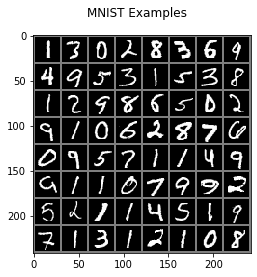

In [3]:
def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()
plt.suptitle('MNIST Examples')
imshow(torchvision.utils.make_grid(images))

We define logistic regression as a two-layer neural net (784 input nodes for pixels, 10 output nodes for digit classification):

In [4]:
class LogReg(nn.Module):
    def __init__(self):
        super(LogReg, self).__init__()
        self.linear = nn.Linear(784, 10)

    def forward(self, x):
        out = self.linear(x)
        return out

Use a grid search to optimize learning rate:

In [5]:
def trainable_logreg(config):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    model = LogReg()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=config["lr"])
    for epoch in range(10):
        model.train()
        running_loss = 0.0

        for inputs, labels in trainloader:
            inputs = inputs.view(inputs.shape[0], -1)
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * inputs.size(0)
            
        tune.report(mean_loss=running_loss/len(trainloader.dataset))

tune.run(trainable_logreg, config={"lr": tune.grid_search([0.01, 0.03, 0.1])}, verbose=1)

Trial name,status,loc,lr,loss,iter,total time (s)
trainable_logreg_bab8b_00000,TERMINATED,,0.01,0.297413,10,189.107
trainable_logreg_bab8b_00001,TERMINATED,,0.03,0.279967,10,188.665
trainable_logreg_bab8b_00002,TERMINATED,,0.1,0.323392,10,188.539


Train the model using stochastic gradient descent. To evaluate the classifier's capabilities, we can we plot the accuracy and loss for training and validation sets as functions of the number of training epochs. Generally, accuracy should continually increase and loss should continually decrease, though with SGD this may not always be true:

In [6]:
def train_model(model, criterion, optimizer, num_epochs, reshape):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    liveloss = PlotLosses()
    model = model.to(device)
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                if reshape:
                    inputs = inputs.view(inputs.shape[0],-1)
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)

            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        
        liveloss.update(logs)
        liveloss.send()

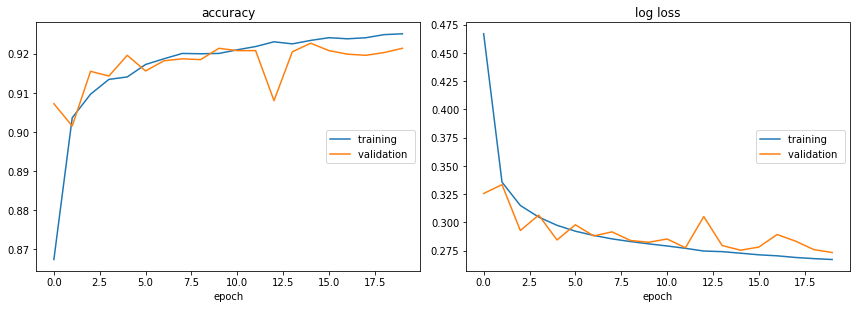

accuracy
	training         	 (min:    0.867, max:    0.925, cur:    0.925)
	validation       	 (min:    0.901, max:    0.923, cur:    0.921)
log loss
	training         	 (min:    0.267, max:    0.467, cur:    0.267)
	validation       	 (min:    0.273, max:    0.333, cur:    0.273)


In [7]:
model=LogReg()
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.03)
num_epochs=20
train_model(model, criterion, optimizer, num_epochs, reshape=True)

We can also plot a confusion matrix to see the classifier's accuracy for different digits:

In [8]:
def confusion_matrix(model,name,reshape):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    cm = torch.zeros(10, 10)
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['validation']):
            if reshape:
                inputs = inputs.view(inputs.shape[0],-1)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(labels.view(-1), preds.view(-1)):
                cm[t.long(), p.long()] += 1

    cm = cm.numpy()
    for i in range(10):
        cm[i] = cm[i]/np.sum(cm[i])
    cm = np.around(cm,3)

    plt.figure(figsize=(10,7))
    df_cm = pd.DataFrame(cm, range(10), range(10))
    sn.set(font_scale=1.3)
    sn.heatmap(df_cm, annot=True, annot_kws={'size': 12}, cmap='Blues')
    plt.suptitle(name + ' Confusion Matrix', fontsize=16)
    plt.show()

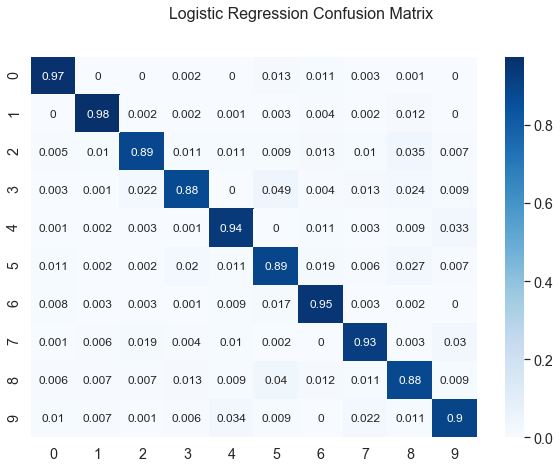

In [9]:
confusion_matrix(model,'Logistic Regression',reshape=True)

## Multilayer Perceptron

We define a MLP with two hidden layers, one with 128 nodes and the other with 64 nodes. Similar to logistic regression, there are 784 input nodes and 10 output nodes: 

In [10]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden_1 = nn.Linear(784,128)
        self.hidden_2 = nn.Linear(128,64)
        self.output = nn.Linear(64,10)

    def forward(self,x):
        x = F.relu(self.hidden_1(x))
        x = F.relu(self.hidden_2(x))
        out = self.output(x)
        return out

In [11]:
def trainable_mlp(config):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    model = MLP()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=config['lr'])
    for epoch in range(10):
        model.train()
        running_loss = 0.0

        for inputs, labels in trainloader:
            inputs = inputs.view(inputs.shape[0], -1)
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * inputs.size(0)

        tune.report(mean_loss=running_loss/len(trainloader.dataset))

tune.run(trainable_mlp, config={'lr': tune.grid_search([0.01, 0.03, 0.1])}, verbose=1)

Trial name,status,loc,lr,loss,iter,total time (s)
trainable_mlp_4e5b7_00000,TERMINATED,,0.01,0.174997,10,190.186
trainable_mlp_4e5b7_00001,TERMINATED,,0.03,0.0794319,10,188.54
trainable_mlp_4e5b7_00002,TERMINATED,,0.1,0.0463838,10,189.077


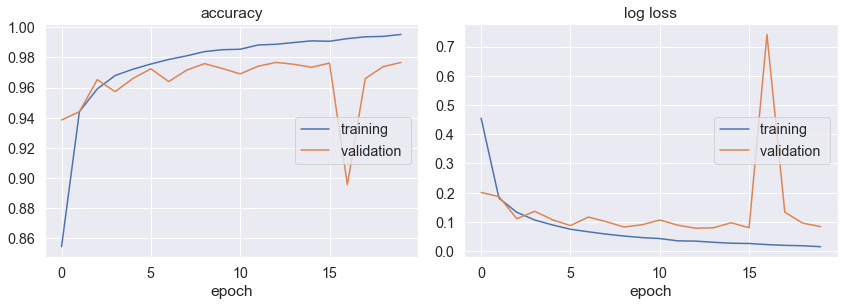

accuracy
	training         	 (min:    0.854, max:    0.995, cur:    0.995)
	validation       	 (min:    0.896, max:    0.977, cur:    0.977)
log loss
	training         	 (min:    0.016, max:    0.455, cur:    0.016)
	validation       	 (min:    0.079, max:    0.741, cur:    0.084)


In [12]:
model=MLP()
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.1)
num_epochs=20
train_model(model, criterion, optimizer, num_epochs, reshape=True)

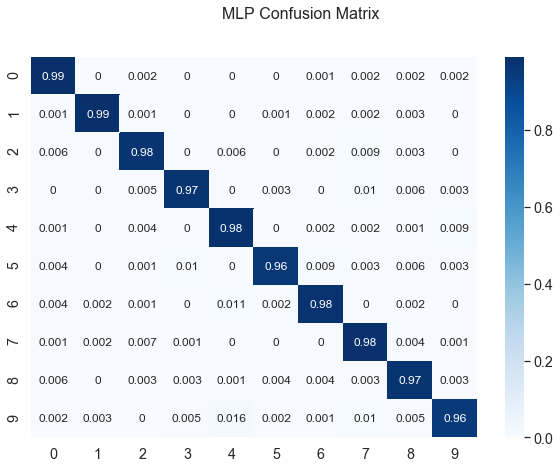

In [13]:
confusion_matrix(model,'MLP',reshape=True)

## Convolutional Neural Network

We define a CNN with two convolution layers, each with 5x5 kernels. We have a max-pooling layer with stride 2 after each convolutional layer. Flattened tensors are then passed throung a dense layer and MLP:

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)

    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = x.reshape(-1, 12*4*4)
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.out(x)
        return x

In [15]:
def trainable_cnn(config):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=config['lr'])
    for epoch in range(5):
        model.train()
        running_loss = 0.0

        for inputs, labels in trainloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * inputs.size(0)

        tune.report(mean_loss=running_loss/len(trainloader.dataset))

tune.run(trainable_cnn, config={'lr': tune.grid_search([0.01, 0.03, 0.1])}, verbose=1)

Trial name,status,loc,lr,loss,iter,total time (s)
trainable_cnn_df3af_00000,TERMINATED,,0.01,0.114151,5,249.979
trainable_cnn_df3af_00001,TERMINATED,,0.03,0.0636285,5,251.377
trainable_cnn_df3af_00002,TERMINATED,,0.1,0.0353578,5,254.954


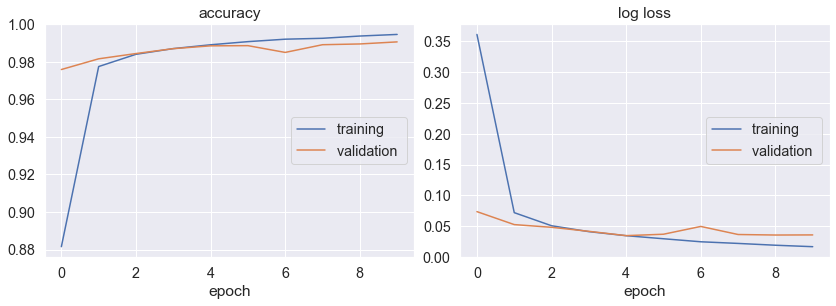

accuracy
	training         	 (min:    0.882, max:    0.994, cur:    0.994)
	validation       	 (min:    0.976, max:    0.990, cur:    0.990)
log loss
	training         	 (min:    0.017, max:    0.361, cur:    0.017)
	validation       	 (min:    0.035, max:    0.074, cur:    0.036)


In [16]:
model=CNN()
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.1)
num_epochs=10
train_model(model, criterion, optimizer, num_epochs, reshape=False)

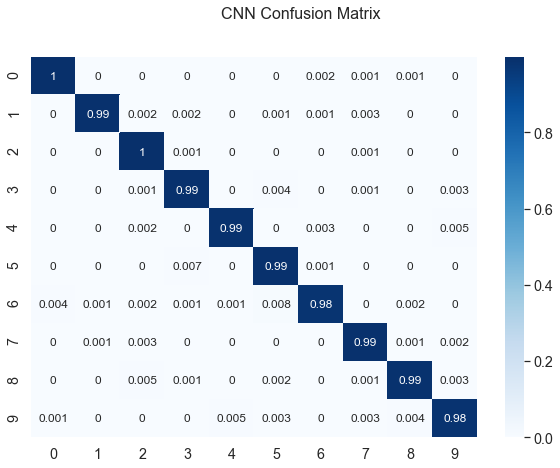

In [17]:
confusion_matrix(model,'CNN',reshape=False)